**The LeNet-5 paper by LeCun et al. (1998) introduced a groundbreaking convolutional neural network (CNN) architecture designed for recognizing handwritten characters, particularly for postal code recognition. Its key innovation was proving that a multi-layered network could be trained end-to-end to learn its own features directly from raw image pixels, which was a huge improvement over traditional methods that relied on hand-crafted features. The paper showcased the power of convolutional layers for feature extraction and pooling layers for downsampling, making the model robust and efficient.**

**While LeNet-5 was originally designed for the simpler MNIST digits, the Fashion-MNIST dataset presents a more complex classification task. The images are visually more ambiguous, with different types of clothing (e.g., shirts, t-shirts, coats) having similar features.**

### Data prep

In [37]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [39]:
train_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [40]:
len(train_data),len(test_data)

(60000, 10000)

In [41]:
class_names = train_data.classes
class_names, len(class_names)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

In [42]:
h = {}
for i in range(len(class_names)):
    h[class_names[i]] = i
h

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [43]:
### both method works
#  encode the labels by using a dictionary : we can use this class_to_idx method
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [44]:
image, label = train_data[0]

### visualizing  image

Image shape: torch.Size([1, 28, 28]) -> [color channels, height, width]
Image label : Ankle boot


Text(0.5, 1.0, 'Ankle boot')

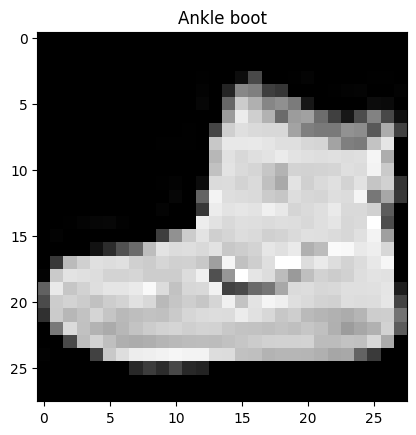

In [45]:
print(f"Image shape: {image.shape} -> [color channels, height, width]")
print(f"Image label : {class_names[label]}")
plt.imshow(image.squeeze(),cmap="gray") #squeeze because img should be (H,W)
plt.title(class_names[label])

In [46]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### DataLoader
it turns out dataset into python iterabel with batches

In [47]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32 ### a hyperparam we can  tune
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [48]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1c9f6ca66d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1c9f6a80d90>)

In [49]:
train_features_batch, train_labels_batch = next(iter(train_dataloader)) ### get one sample of image and lable
train_features_batch.shape, train_labels_batch.shape # batch size, color channel, H, W

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### **CNN Model (Convolution Neural Network)**

In [50]:
class CNN(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)      
        )
        # now a liner layer to classify 
        self.classifier = nn.Sequential(
            nn.Flatten(),#  to reduce dim 1
            nn.Linear(in_features=hidden_units * 7 *7, ### this can be determined by the first shape mistmatch error it throws
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        # print(f"output shape of conv block 1: {x.shape}")
        x = self.conv_block2(x)
        # print(f"output shape of conv block 2: {x.shape}")
        x = self.classifier(x)
        # print(f"output shape of classifier: {x.shape}")

        return x

In [51]:
cnn_model = CNN(input_shape=1,
                hidden_units=10,
                output_shape=len(class_names)).to(device)

In [52]:
cnn_model

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### loss fn and optimizer

In [53]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = cnn_model.parameters(),
                            lr = 0.1)

### TRAIN and TEST Functions

In [59]:
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device):
    model.train()
    train_loss = 0
    train_acc = 0

    for batch, (X,y) in enumerate(data_loader):
        X,y = X.to(device), y.to(device)

        #1. forward pass
        y_pred =  model(X)

        #2. Calculate loss
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        #3.
        optimizer.zero_grad()

        #4 backprop
        loss.backward()

        #5
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1),dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(data_loader)
    train_acc  = train_acc / len(data_loader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device):
    model.eval() # Set the model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate the loss
            test_loss += loss_fn(test_pred, y).item()

            # Calculate accuracy for this batch
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Adjust metrics to get the average loss and accuracy per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    return test_loss, test_acc

In [61]:
from tqdm.auto import tqdm 


epochs = 10

results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []}

# Loop through each epoch
for epoch in tqdm(range(epochs)):
    # Perform training step
    train_loss, train_acc = train_step(model=cnn_model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    # Perform testing step
    test_loss, test_acc = test_step(model=cnn_model,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch+1} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | "
          f"Test Acc: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.2434 | Train Acc: 0.9096 | Test Loss: 0.2948 | Test Acc: 0.8943
Epoch: 2 | Train Loss: 0.2412 | Train Acc: 0.9124 | Test Loss: 0.3108 | Test Acc: 0.8858
Epoch: 3 | Train Loss: 0.2391 | Train Acc: 0.9118 | Test Loss: 0.2857 | Test Acc: 0.8952
Epoch: 4 | Train Loss: 0.2330 | Train Acc: 0.9155 | Test Loss: 0.2792 | Test Acc: 0.9003
Epoch: 5 | Train Loss: 0.2321 | Train Acc: 0.9153 | Test Loss: 0.2886 | Test Acc: 0.8983
Epoch: 6 | Train Loss: 0.2301 | Train Acc: 0.9159 | Test Loss: 0.2850 | Test Acc: 0.8949
Epoch: 7 | Train Loss: 0.2279 | Train Acc: 0.9168 | Test Loss: 0.2854 | Test Acc: 0.8944
Epoch: 8 | Train Loss: 0.2254 | Train Acc: 0.9172 | Test Loss: 0.2814 | Test Acc: 0.8999
Epoch: 9 | Train Loss: 0.2240 | Train Acc: 0.9183 | Test Loss: 0.2762 | Test Acc: 0.8980
Epoch: 10 | Train Loss: 0.2217 | Train Acc: 0.9189 | Test Loss: 0.2889 | Test Acc: 0.8971


Original image shape: torch.Size([1, 28, 28])
New image shape with batch dimension: torch.Size([1, 1, 28, 28])


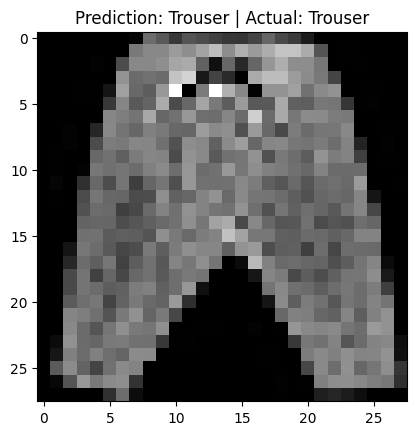

Prediction probability: 0.9877
Prediction label index: 1
Actual label index: 1


In [68]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Set the model to evaluation mode
cnn_model.eval()

# Grab a single image from the test_data
img, label = test_data[random.randint(0, len(test_data)-1)]
print(f"Original image shape: {img.shape}")

# Add a batch dimension to the image
img_unsqueeze = img.unsqueeze(dim=0).to(device)
print(f"New image shape with batch dimension: {img_unsqueeze.shape}")

# Make a prediction
with torch.inference_mode():
    pred_logits = cnn_model(img_unsqueeze)

# Convert logits to prediction probabilities
pred_probs = torch.softmax(pred_logits, dim=1)

# Convert prediction probabilities to prediction labels
pred_label = torch.argmax(pred_probs, dim=1)

# Plot the image and print the prediction
plt.imshow(img.squeeze().cpu(), cmap="gray")
plt.title(f"Prediction: {class_names[pred_label.item()]} | Actual: {class_names[label]}")
plt.show()

print(f"Prediction probability: {pred_probs.max().item():.4f}")
print(f"Prediction label index: {pred_label.item()}")
print(f"Actual label index: {label}")